# Health Impact Classification

#### Data Description

##### Record Information
RecordID: A unique identifier assigned to each record (1 to 2392).

##### Air Quality Metrics
AQI: Air Quality Index, a measure of how polluted the air currently is or how polluted it is forecast to become.<br>
PM10: Concentration of particulate matter less than 10 micrometers in diameter (μg/m³).<br>
PM2_5: Concentration of particulate matter less than 2.5 micrometers in diameter (μg/m³).<br>
NO2: Concentration of nitrogen dioxide (ppb).<br>
SO2: Concentration of sulfur dioxide (ppb).<br>
O3: Concentration of ozone (ppb).<br>

##### Weather Conditions
Temperature: Temperature in degrees Celsius (°C).<br>
Humidity: Humidity percentage (%).<br>
WindSpeed: Wind speed in meters per second (m/s).<br>

##### Health Impact Metrics
RespiratoryCases: Number of respiratory cases reported.<br>
CardiovascularCases: Number of cardiovascular cases reported.<br>
HospitalAdmissions: Number of hospital admissions reported.<br>

##### Target Variable: Health Impact Class
HealthImpactScore: A score indicating the overall health impact based on air quality and other related factors, ranging from 0 to 100.<br>
HealthImpactClass: Classification of the health impact based on the health impact score:<br>

0: 'Very High' (HealthImpactScore >= 80)<br>
1: 'High' (60 <= HealthImpactScore < 80)<br>
2: 'Moderate' (40 <= HealthImpactScore < 60)<br>
3: 'Low' (20 <= HealthImpactScore < 40)<br>
4: 'Very Low' (HealthImpactScore < 20)<br>

### Set-Up and Load Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr

# Import CSV as DataFrame
df = pd.read_csv('data/air_quality_health_impact_data.csv')
print(df.head()) # Preview first 5 rows

   RecordID         AQI        PM10       PM2_5         NO2        SO2  \
0         1  187.270059  295.853039   13.038560    6.639263  66.161150   
1         2  475.357153  246.254703    9.984497   16.318326  90.499523   
2         3  365.996971   84.443191   23.111340   96.317811  17.875850   
3         4  299.329242   21.020609   14.273403   81.234403  48.323616   
4         5   78.009320   16.987667  152.111623  121.235461  90.866167   

           O3  Temperature   Humidity  WindSpeed  RespiratoryCases  \
0   54.624280     5.150335  84.424344   6.137755                 7   
1  169.621728     1.543378  46.851415   4.521422                10   
2    9.006794     1.169483  17.806977  11.157384                13   
3   93.161033    21.925276  99.473373  15.302500                 8   
4  241.795138     9.217517  24.906837  14.534733                 9   

   CardiovascularCases  HospitalAdmissions  HealthImpactScore  \
0                    5                   1          97.244041   
1   

In [ ]:
# Dataset Size and Structure
df.shape  # 5811 rows, 15 columns

### Pre-Processing

In [ ]:
# No missing values
df.isnull().sum()

In [12]:
# Remove identifier, redundant for prediction analysis
df = df.drop(columns=["RecordID"], errors="ignore")

### Exploratory Data Analysis (EDA)

In [9]:
# Datatypes and Missing Values
df.info() # Integer - int64(4) and Float - float64(11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5811 entries, 0 to 5810
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RecordID             5811 non-null   int64  
 1   AQI                  5811 non-null   float64
 2   PM10                 5811 non-null   float64
 3   PM2_5                5811 non-null   float64
 4   NO2                  5811 non-null   float64
 5   SO2                  5811 non-null   float64
 6   O3                   5811 non-null   float64
 7   Temperature          5811 non-null   float64
 8   Humidity             5811 non-null   float64
 9   WindSpeed            5811 non-null   float64
 10  RespiratoryCases     5811 non-null   int64  
 11  CardiovascularCases  5811 non-null   int64  
 12  HospitalAdmissions   5811 non-null   int64  
 13  HealthImpactScore    5811 non-null   float64
 14  HealthImpactClass    5811 non-null   int64  
dtypes: float64(10), int64(5)
memory usage:

In [ ]:
# Statistical Summary
df.describe().T # Count, mean, standard devation, minimum, maximum, and quartiles
# Central Tendency and Spread of Data

In [ ]:
df.nunique() # Variety of values and duplicty

#### Univariate Analysis

##### Numerical Values

In [ ]:
# Distribution
# sns.histplot(df['AQI'], kde=True)
# plt.title('AQI Distribution')
# plt.show()

In [ ]:
# Boxplots
# sns.boxplot(x=df['PM2_5'])
# plt.title('PM2.5 Spread and Outliers')
# plt.show()

##### Categorial Values

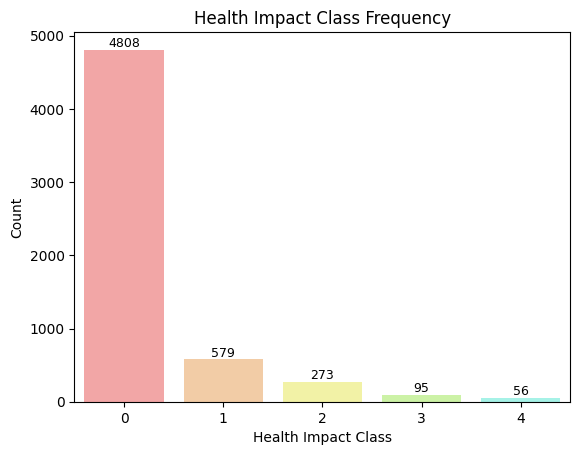

In [ ]:
# Health Impact Class
# Bar Chart Palette
custom_colors = ["#FF9999", '#FFCC99', '#FFFF99', '#CCFF99', "#99FFF0"]
# Plot counts
ax = sns.countplot(x='HealthImpactClass', hue='HealthImpactClass', data=df, palette=custom_colors, legend=False)
# Title
plt.title('Health Impact Class Frequency')
# Add count labels 
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', 
                fontsize=9, color='black')
ax.set(xlabel='Health Impact Class', ylabel='Count')
plt.show()
# Data heavily skewed towards health impact of 
#print(df['HealthImpactClass'].value_counts())

### Bivariate Analysis

Multivariate Analysis

In [ ]:
# Kernel density plot - Understanding variance
sns.set_style("darkgrid")

numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))

sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

### Feature Selection

### Training the Model

### Testing the Model

### Performance Evaluation